# Book recommendation project: EDA + data wrangling

In [1]:
# importing standard Python libraries for data analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
# I would like to see all rows and columns of dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# do not show warnings
import warnings
warnings.filterwarnings('ignore')

## Exploratory data analysis of datasets and data cleaning

### Ratings dataset

In [3]:
# checking the 3 datasets available from http://www2.informatik.uni-freiburg.de/~cziegler/BX/ 
# looking at ratings dataset
ratings = pd.read_csv('ratings.csv', sep=';', encoding='ISO-8859–1')
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [4]:
# checking non_nulls and data types from ratings dataset
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [5]:
# minor changes for easier manipulation with column names
ratings.columns = ratings.columns.str.lower()
ratings.columns

Index(['user-id', 'isbn', 'book-rating'], dtype='object')

In [6]:
ratings.columns =['user', 'isbn', 'rating']

In [7]:
# correction of wrong ISBN entries with dots
ratings["isbn"] = ratings["isbn"].str.replace('.',  '')
ratings["isbn"] = ratings["isbn"].str.replace(')',  '')

In [8]:
# how many books do we have in ratings dataset?
ratings.isbn.nunique()

340329

In [9]:
# eyeballing values in dataset we can see some ISBNs are not in 10-digits format
ratings.head(10)

,user,isbn,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10


In [10]:
# ISBN longer than 10 digits shows different patterns, probably it will be hard to repair -> likely data to remove
ratings[ratings.isbn.str.len()>10].head(15)

,user,isbn,rating
55,276762,N3453124715,4
337,276875,014366020444,8
368,276875,88741800047,8
541,276929,20202006935,8
542,276929,20203119888,8
583,276929,22660861003,6
677,276959,680ISBN359623,6
839,277074,9782922145441,5
1073,277187,44901766125,0
1184,277196,044920597545,0


In [11]:
# ISBNs shorter 10 digits are most likely missing 0 in the beginning
ratings[ratings.isbn.str.len()<10].head(15)

,user,isbn,rating
9,276745,342310538,10
40,276762,342662429,0
247,276856,20103389,0
291,276861,344242529,9
336,276875,00273755,7
383,276884,899792145,0
489,276925,842975295,0
575,276929,226403114,5
582,276929,226604960,8
823,277051,06514251,0


In [12]:
# what is share of wrong ISBNs in dataset?
len(ratings[ratings.isbn.str.len()!=10])/len(ratings.isbn)

0.008591208752978832

In [13]:
# how many wrong ISBNs there is?
len(ratings[ratings.isbn.str.len()!=10])

9878

In [14]:
# correction of shorter ISBNs: adding zeros for missing characters
ratings.isbn = ratings.isbn.str.zfill(10)

In [15]:
# we solved more then half of problematic ISBNs
len(ratings[ratings.isbn.str.len()!=10])

4005

In [16]:
# wrong longer ISBNs will be removed
ratings = ratings[ratings.isbn.str.len() == 10]

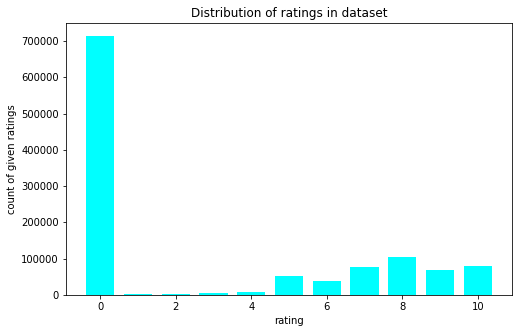

In [17]:
# checking distribution of ratings
bins = np.arange(ratings.rating.min(), ratings.rating.max()+2, 1)

plt.figure(figsize=(8, 5))
plt.hist(data=ratings, x="rating", bins= bins, facecolor = 'cyan', rwidth=0.75, align='left')
plt.title("Distribution of ratings in dataset")
plt.xlabel("rating")
plt.ylabel("count of given ratings")
plt.show()

Many zeros means no ratings were given to those books. When a book was not rated, it holds no information for our book recommendation system, therefore these records will be deleted from dataset. But before I will create variable *reaction_index* which equals total number of ratings per book/ total number of reading/buying of book.

In [18]:
# createing new variable reaction_index
count_read = (ratings.groupby(['isbn']).count()).reset_index()
count_read.rename(columns={'rating': 'c_read'}, inplace=True)

rated = ratings[ratings.rating>0]
count_rated = (rated.groupby(['isbn']).count()).reset_index()
count_rated.rename(columns={'rating': 'c_rated'}, inplace=True)

In [19]:
ratings = pd.merge(ratings, count_read, on="isbn")
ratings = pd.merge(ratings, count_rated, on="isbn")

In [20]:
ratings["reaction_index"] = ratings.c_rated/ratings.c_read
ratings.head()

,user_x,isbn,rating,user_y,c_read,user,c_rated,reaction_index
0,276725,034545104X,0,60,60,28,28,0.466667
1,2313,034545104X,5,60,60,28,28,0.466667
2,6543,034545104X,0,60,60,28,28,0.466667
3,8680,034545104X,5,60,60,28,28,0.466667
4,10314,034545104X,9,60,60,28,28,0.466667


In [21]:
ratings.columns

Index(['user_x', 'isbn', 'rating', 'user_y', 'c_read', 'user', 'c_rated',
       'reaction_index'],
      dtype='object')

In [22]:
ratings = ratings[['user_x', 'isbn', 'rating', 'reaction_index']]
ratings.rename(columns={'user_x': 'user'}, inplace=True)

In [23]:
# removing records without any rating
ratings = ratings[ratings.rating>0]

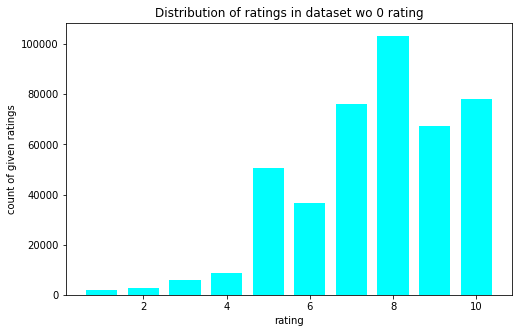

In [24]:
# checking distribution of ratings after the change
bins = np.arange(ratings.rating.min(), ratings.rating.max()+2, 1)

plt.figure(figsize=(8, 5))
plt.hist(data=ratings, x="rating", bins= bins, facecolor = 'cyan', rwidth=0.75, align='left')
plt.title("Distribution of ratings in dataset wo 0 rating")
plt.xlabel("rating")
plt.ylabel("count of given ratings")
plt.show()

In [25]:
per_good_rating = (round((len(ratings[ratings.rating>6])/len(ratings.rating)), 2))*100
f"Readers actually give very good ratings, {per_good_rating} % of all books are rated 7 or higher."

'Readers actually give very good ratings, 75.0 % of all books are rated 7 or higher.'

It would be interesting to know, which books are rated the best. For that we need to create new variable.

In [26]:
# create average rating for each book
avg_rating = ratings.groupby(['isbn']).mean()
avg_rating.rename(columns={'rating': 'avg_rating'}, inplace=True)
avg_rating.drop(['reaction_index','user'], axis=1, inplace=True)
avg_rating.sample(15)

,avg_rating
isbn,
0446604275,7.050000
0803281730,10.000000
0316693286,7.823529
8508040016,9.000000
1410731472,8.000000
0743223748,6.000000
8818121685,10.000000
0763617059,8.000000
0689711670,9.000000


Results of average ratings for the books are suggesting that there is high number of books rated just once. We need to investigate it further, because average rating for book rated only once is not comparable to the book rated by many readers.

In [27]:
# checking how many times are books rated the most often
count_rating = ratings.groupby(['isbn']).count()
count_rating.value_counts().head(15)

user  rating  reaction_index
1     1       1                 127687
2     2       2                  26194
3     3       3                  10159
4     4       4                   5375
5     5       5                   3284
6     6       6                   2131
7     7       7                   1495
8     8       8                   1148
9     9       9                    838
10    10      10                   683
11    11      11                   546
12    12      12                   469
13    13      13                   366
14    14      14                   336
15    15      15                   322
dtype: int64

In [28]:
# how many books were rated at least 5 times?
round(len(count_rating[count_rating.rating>2])/len(count_rating), 2), len(count_rating[count_rating.rating>4])

(0.16, 14546)

In [29]:
# adding new variable to see how many times was a book rated
count_rating.rename(columns={'rating': 'rating_count'}, inplace=True)
count_rating = count_rating.reset_index()

In [30]:
# deleting books rated less than 5 times
count_rating = count_rating[count_rating.rating_count>4]
count_rating = count_rating[['isbn', 'rating_count']]

In [31]:
# adding new variables to ratings dataset
ratings = pd.merge(ratings, count_rating, on="isbn", how="right")
ratings = pd.merge(ratings, avg_rating, on="isbn", how="left")
ratings.head(10)

,user,isbn,rating,reaction_index,rating_count,avg_rating
0,8094,0000000000,10,0.310345,9,6.777778
1,11676,0000000000,9,0.310345,9,6.777778
2,11795,0000000000,7,0.310345,9,6.777778
3,11795,0000000000,7,0.310345,9,6.777778
4,71285,0000000000,7,0.310345,9,6.777778
5,120548,0000000000,6,0.310345,9,6.777778
6,149452,0000000000,1,0.310345,9,6.777778
7,218187,0000000000,9,0.310345,9,6.777778
8,263063,0000000000,5,0.310345,9,6.777778
9,8,0002005018,5,0.642857,9,7.666667


In [32]:
# checking number of unique books
ratings.isbn.nunique()

14546

### Users dataset

In [33]:
# checking second dataset about readers
users = pd.read_csv('users.csv', sep=';', encoding='ISO-8859–1')
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [34]:
# checking data types and null values
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [35]:
# lowercase for column names for easier manipulation
users.columns = users.columns.str.lower()
users.columns

Index(['user-id', 'location', 'age'], dtype='object')

In [36]:
# dividing location into 3 separate variables
users[["city", "region", "country"]] = users["location"].str.split(", ", n = 2, expand = True)
# droping redundant column location and not very useful region
users.drop(['location','region'], axis=1, inplace=True)
# better column name
users.rename(columns={'user-id': 'user'}, inplace=True)

In [37]:
# checking dataset after changes
users.head()

,user,age,city,country
0,1,NaN,nyc,usa
1,2,18.0,stockton,usa
2,3,NaN,moscow,russia
3,4,17.0,porto,portugal
4,5,NaN,farnborough,united kingdom


In [38]:
# checking values for age
users.age.value_counts()

24.0     5687
25.0     5618
26.0     5547
23.0     5456
27.0     5383
28.0     5347
29.0     5293
32.0     4781
30.0     4778
22.0     4714
33.0     4699
31.0     4665
34.0     4656
21.0     4438
35.0     4194
20.0     4056
19.0     3950
36.0     3896
18.0     3703
37.0     3582
38.0     3404
39.0     3234
40.0     3142
17.0     3044
41.0     2919
43.0     2816
42.0     2758
44.0     2745
16.0     2570
46.0     2526
45.0     2518
47.0     2512
49.0     2461
15.0     2383
50.0     2340
48.0     2303
51.0     2203
54.0     2140
52.0     2077
53.0     2072
14.0     1962
55.0     1885
57.0     1878
56.0     1692
58.0     1319
59.0     1205
60.0     1125
61.0     1035
13.0      885
62.0      882
63.0      792
64.0      680
65.0      593
66.0      545
67.0      465
68.0      426
0.0       416
69.0      373
70.0      315
1.0       288
71.0      286
72.0      223
73.0      200
104.0     192
12.0      192
74.0      170
11.0      121
75.0      119
76.0      114
2.0       105
10.0       84
77.0  

There are some suspicious values as 0, 1 or 2 (people can't read nor rate books at this age) or age over 200 years. I will change these bizarre ages to NaN.

In [39]:
# weird ages changed to NaN values
users.age = np.where(((users['age']>120.0) | (users['age']<6.0)), np.nan, users['age'])

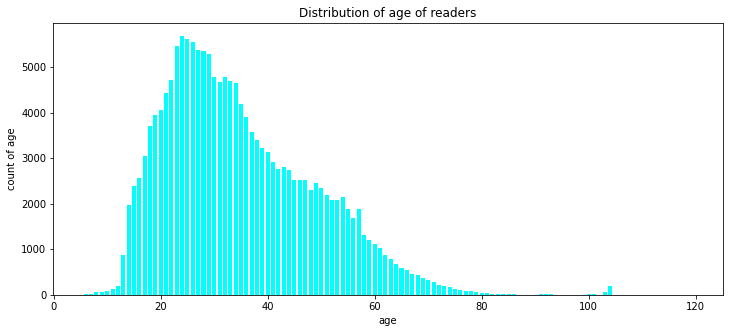

In [40]:
# checking distribution of ratings after the change
bins = np.arange(users.age.min(), users.age.max()+2.0, 1.0)

plt.figure(figsize=(12, 5))
plt.hist(data=users, x="age", bins= bins, facecolor = 'cyan', rwidth=0.75, align='left')
plt.title("Distribution of age of readers")
plt.xlabel("age")
plt.ylabel("count of age")
plt.show()

In [41]:
# checking country values
users.country.value_counts()

usa                                                                 139421
canada                                                               21601
united kingdom                                                       18314
germany                                                              17024
spain                                                                13096
australia                                                            11730
italy                                                                11244
france                                                                3440
portugal                                                              3312
new zealand                                                           3072
netherlands                                                           3019
switzerland                                                           1739
brazil                                                                1668
china                    

We could see there is uselss " character and some countries kept name of region or city as well. These issues needs to be addressed

In [42]:
# deleting useless character in country names
users['country'].replace('"', '', inplace=True, regex=True)

In [43]:
# create new dataframe only with country names to be corrected
country_cor = users.set_index('user')
country_cor = country_cor.loc[(country_cor.country.str.contains(pat =","))==True]
country_cor.head()

,age,city,country
user,,,
436,53.0,ivanhoe,"victoria, australia"
815,43.0,davis bay,"british columbia, canada"
841,24.0,saint charles,"missouri, usa"
1460,34.0,mansoura,"mansoura, egypt"
1521,NaN,washington,"dc, usa"


In [44]:
# split country names into 2 columns anf check result
country_cor = country_cor.country.str.rsplit(", ", 1, expand=True)
country_cor.head(5)

,0,1
user,,
436,victoria,australia
815,british columbia,canada
841,missouri,usa
1460,mansoura,egypt
1521,dc,usa


In [45]:
# keep only country name
country_cor.drop(0, axis=1, inplace=True)

In [46]:
# change column name and create dictionary of users as keys and correct country names as values
country_cor.columns = ["country"]
country_dict = dict(zip(country_cor.index, country_cor.country))

In [47]:
# check dictionary
list(country_dict.items())[:4]

[(436, 'australia'), (815, 'canada'), (841, 'usa'), (1460, 'egypt')]

In [48]:
# create function to add corrected country names if user is found in the dictionary

cor_list = list(country_dict.keys())
country_cor = []

    
for i in list(range(1, 278859, 1)):
    if i in cor_list:
        country_cor.append((country_dict[i]))
    else:
        country_cor.append(users.country[i-1])

In [49]:
# add new variable with corrected country names to users dataset
users["country_2"] = country_cor

In [50]:
# check random entry with correction to verify everything is OK
users[users["user"]== 436]

,user,age,city,country,country_2
435,436,53.0,ivanhoe,"victoria, australia",australia


In [51]:
# value counts stats for uncorrected countries and corrected ones give us idea how many changes were made
(users.country.value_counts()).head(10)

usa               139422
canada             21601
united kingdom     18332
germany            17054
spain              13206
australia          11731
italy              11249
france              3472
portugal            3377
new zealand         3095
Name: country, dtype: int64

In [52]:
(users.country_2.value_counts()).head(10)

usa               139712
canada             21658
united kingdom     18556
germany            17073
spain              13258
australia          11785
italy              11271
france              3487
portugal            3390
new zealand         3120
Name: country_2, dtype: int64

In [53]:
# join of users and ratings dataset
readers = pd.merge(users, ratings, on="user")

In [54]:
# checking new dataframe
readers.head(10)

,user,age,city,country,country_2,isbn,rating,reaction_index,rating_count,avg_rating
0,8,NaN,timmins,canada,canada,0002005018,5,0.642857,9,7.666667
1,9,NaN,germantown,usa,usa,0452264464,6,0.438889,79,7.772152
2,16,NaN,albuquerque,usa,usa,0345402871,9,0.381643,79,7.455696
3,17,NaN,chesapeake,usa,usa,0425099148,7,0.352941,6,8.666667
4,17,NaN,chesapeake,usa,usa,0553264990,5,0.538462,7,8.000000
5,17,NaN,chesapeake,usa,usa,0891075275,6,0.437500,21,8.714286
6,17,NaN,chesapeake,usa,usa,0891076182,3,0.361111,13,6.615385
7,19,14.0,weston,None,None,0375759778,7,0.518519,14,6.571429
8,26,NaN,bellevue,usa,usa,0446310786,10,0.550129,214,8.943925
9,26,NaN,bellevue,usa,usa,0449005615,9,0.487805,120,8.483333


In [55]:
# keeping just useful columns in dataset
readers = readers[['user', 'age', 'country_2', 'isbn', 'rating', 'rating_count', 'avg_rating', 'reaction_index']]

In [56]:
readers.head()

,user,age,country_2,isbn,rating,rating_count,avg_rating,reaction_index
0,8,NaN,canada,0002005018,5,9,7.666667,0.642857
1,9,NaN,usa,0452264464,6,79,7.772152,0.438889
2,16,NaN,usa,0345402871,9,79,7.455696,0.381643
3,17,NaN,usa,0425099148,7,6,8.666667,0.352941
4,17,NaN,usa,0553264990,5,7,8.000000,0.538462


### Books dataset

In [57]:
# checking books dataset that were before manually changed in Excel 
# (&amp; to &, otherwise &amp; is problem when reading dataset)
books = pd.read_csv('books2.csv', delimiter=";", encoding='ISO-8859–1', low_memory=False)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,NaN,NaN,NaN
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,NaN,NaN,NaN
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,NaN,NaN,NaN
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,NaN,NaN,NaN
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,NaN,NaN,NaN


In [58]:
# how many books?
books.shape

(271379, 11)

In [59]:
# lowercase for columns
books.columns = books.columns.str.lower()

In [60]:
# list of colum name for easier copypaste
books.columns

Index(['isbn', 'book-title', 'book-author', 'year-of-publication', 'publisher',
       'image-url-s', 'image-url-m', 'image-url-l', 'unnamed: 8', 'unnamed: 9',
       'unnamed: 10'],
      dtype='object')

In [61]:
# previous copypaste used to keep only useful columns
books = books[['isbn', 'book-title', 'book-author', 'year-of-publication', 'publisher']]

In [62]:
# shorter column names
books.columns = ['isbn', 'title', 'author', 'year', 'publisher']

In [63]:
# eyeballing values from books dataset
books.head(15)

,isbn,title,author,year,publisher
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company
5,399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
6,425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group
7,671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks
8,679425608,Under the Black Flag: The Romance and the Real...,David Cordingly,1996,Random House
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner


In [64]:
# how many ISBNs are shorter than 10 digits?
len(books[books.isbn.str.len()<10])

199601

From first 15 rows it looks like shorter ISBNs weere cause by missing zeros as in previous datasets.

In [65]:
# adding missing zeros to shorter ISBNs
books.isbn = books.isbn.str.zfill(10)

In [66]:
# Are there some longer ISBNs?
len(books[books.isbn.str.len()!=10])

4

In [67]:
# check longer ISBNs
books[books.isbn.str.len()!=10]

,isbn,title,author,year,publisher
111813,0486404242\t,War in Kind: And Other Poems (Dover Thrift Edi...,Stephen Crane,1998,Dover Publications
171215,3518365479<90,"Suhrkamp TaschenbÃ?Â¼cher, Nr.47, Frost",Thomas Bernhard,1972,Suhrkamp
251441,3442248027 3,Diamond Age. Die Grenzwelt.,Neal Stephenson,2000,Goldmann
251666,0385722206 0,Balzac and the Little Chinese Seamstress : A N...,DAI SIJIE,2002,Anchor


There is no clear pattern what is wrong with these ISBNs. For just 4 records it is useless to spend more time on investigating, these records will be simply removed.

In [68]:
# removing longer ISBNs
books = books[books.isbn.str.len()==10]

In [69]:
# how many unique books do we have?
isbn_list = list(books.isbn.unique())
len(isbn_list)

271375

In [70]:
# creating one dataframe with all info about books that were rated and readers who rated them
books_readers = pd.merge(readers, books, on="isbn")
books_readers.head(25)

,user,age,country_2,isbn,rating,rating_count,avg_rating,reaction_index,title,author,year,publisher
0,8,NaN,canada,0002005018,5,9,7.666667,0.642857,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
1,11676,NaN,n/a,0002005018,8,9,7.666667,0.642857,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,67544,30.0,canada,0002005018,8,9,7.666667,0.642857,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
3,116866,NaN,None,0002005018,9,9,7.666667,0.642857,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
4,123629,NaN,canada,0002005018,9,9,7.666667,0.642857,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
5,200273,NaN,canada,0002005018,8,9,7.666667,0.642857,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
6,210926,NaN,canada,0002005018,9,9,7.666667,0.642857,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
7,219008,60.0,canada,0002005018,7,9,7.666667,0.642857,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
8,263325,27.0,canada,0002005018,6,9,7.666667,0.642857,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
9,9,NaN,usa,0452264464,6,79,7.772152,0.438889,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume


In [71]:
# how many entries do we have in new dataset?
books_readers.shape

(192534, 12)

In [72]:
# checking again country values because there are some n/a, none etc.
books_readers.country_2.value_counts()

usa                                    140925
canada                                  17937
united kingdom                           5115
germany                                  4019
n/a                                      3110
australia                                2681
spain                                    1892
portugal                                 1557
france                                   1214
malaysia                                 1020
netherlands                               795
new zealand                               685
italy                                     657
switzerland                               561
austria                                   374
singapore                                 308
philippines                               254
brazil                                    218
japan                                     206
finland                                   204
china                                     190
romania                           

In [73]:
# lists for correction of the most common multiple variants of one country name
usa_readers = ['usa', 'us', 'united states', 'united state', 'u.s.a']
uk_readers = ['united kingdom', 'england', 'wales', 'united kindgonm', 'u.k.']
nz_readers = ['new zealand', 'nz']

In [74]:
# correction of these country names
books_readers.country_2 = books_readers.country_2.apply(lambda x: "usa" if x in usa_readers else x)
books_readers.country_2 = books_readers.country_2.apply(lambda x: "uk" if x in uk_readers else x)
books_readers.country_2 = books_readers.country_2.apply(lambda x: "nz" if x in nz_readers else x)

In [75]:
# checking result of changes
(books_readers.country_2.value_counts()).head(20)

usa            141042
canada          17937
uk               5127
germany          4019
n/a              3110
australia        2681
spain            1892
portugal         1557
france           1214
malaysia         1020
netherlands       795
nz                686
italy             657
switzerland       561
austria           374
singapore         308
philippines       254
brazil            218
japan             206
finland           204
Name: country_2, dtype: int64

In [76]:
# deleting most countries besides 10 selected speaking countries
country_keep = ['usa', 'uk', 'nz', 'canada', 'australia', 'germany', 'spain', 'france', 'portugal', 'malaysia']
books_readers.country_2 = books_readers.country_2.apply(lambda x: "other" if x not in country_keep else x)

In [77]:
# checking country distribution after changes
books_readers.country_2.value_counts()

usa          141042
canada        17937
other         15359
uk             5127
germany        4019
australia      2681
spain          1892
portugal       1557
france         1214
malaysia       1020
nz              686
Name: country_2, dtype: int64

In [78]:
# create median age of raters for each book
age_raters = (books_readers.groupby(['isbn'])["age"].median()).reset_index()
age_raters.rename(columns={'age': 'median_age_raters'}, inplace=True)
age_raters.head(10)

,isbn,median_age_raters
0,0002005018,30.0
1,0002251760,27.5
2,0002259834,24.0
3,0002558122,32.5
4,0003300277,29.0
5,0006385427,28.0
6,0006471641,41.0
7,0006480764,42.0
8,000648302X,27.0
9,0006485200,51.0


In [79]:
books_readers = pd.merge(books_readers, age_raters, on="isbn")
books_readers.sample(5)

,user,age,country_2,isbn,rating,rating_count,avg_rating,reaction_index,title,author,year,publisher,median_age_raters
116238,203764,48.0,usa,0449213730,10,18,7.666667,0.439024,The Ritual Bath (Peter Decker & Rina Lazarus N...,Faye Kellerman,1991,Fawcett Books,41.5
10582,43246,36.0,canada,015600710X,9,26,8.153846,0.433333,Strange Fits of Passion: A Novel,Anita Shreve,1999,Harvest Books,40.0
174675,207979,NaN,usa,0786864672,7,10,7.300000,0.333333,Pure Drivel,Steve Martin,1998,Hyperion,42.0
90008,88793,25.0,usa,0609810103,6,10,6.200000,0.666667,Diary of a Manhattan Call Girl,Tracy Quan,2003,Three Rivers Press (CA),35.0
8162,66690,NaN,other,8845229041,8,5,5.600000,0.555556,Biblioteca Universale Rizzoli: Sulla Sponda De...,P Coelho,0,Fabbri - RCS Libri,30.0


In [80]:
# checking books by selected author
tolkien_books = books_readers.loc[books_readers['author'].str.contains(pat="Tolkien")==True]
tolkien_books.sample(25)

,user,age,country_2,isbn,rating,rating_count,avg_rating,reaction_index,title,author,year,publisher,median_age_raters
146490,223953,29.0,usa,0618260250,10,10,9.000000,0.714286,The Lord of the Rings,J. R. R. Tolkien,2002,Houghton Mifflin Company,28.0
150771,85526,36.0,canada,0395071224,10,6,9.666667,0.750000,The Hobbit,J. R. R. Tolkien,1938,Houghton Mifflin Company,34.0
13484,643,23.0,france,2253049417,9,8,8.875000,0.666667,"Bilbo, Le Hobbit",J. R. R. Tolkien,2002,Pocket (FR),23.0
186239,276847,27.0,germany,360893541X,10,7,8.571429,0.777778,Die Gefahrten I,J. R. R. Tolkien,2001,Distribooks,25.5
127646,142149,26.0,usa,0618002235,10,25,9.720000,0.641026,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,1999,Houghton Mifflin Company,30.5
1242,264117,35.0,spain,8445071408,8,13,8.076923,0.812500,El Senor De Los Anillos: LA Comunidad Del Anil...,J. R. R. Tolkien,2001,Minotauro,26.0
189109,169682,26.0,usa,0345400437,5,5,5.600000,0.384615,The Shaping of Middle-Earth (The History of Mi...,J. R. R. Tolkien,1995,Del Rey Books,26.0
127635,15128,22.0,other,0618002235,9,25,9.720000,0.641026,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,1999,Houghton Mifflin Company,30.5
87237,254206,31.0,usa,0395177111,10,18,9.055556,0.750000,The Hobbit (Leatherette Collector's Edition),J. R. R. Tolkien,1973,Houghton Mifflin Company,38.5
6362,87555,31.0,usa,0618002227,10,43,9.093023,0.682540,The Fellowship of the Ring (The Lord of the Ri...,J. R. R. Tolkien,1999,Houghton Mifflin Company,31.0


In [81]:
# how many unique books do we have now?
books_readers_list = list(books_readers.isbn.unique())
len(books_readers_list)

13805

### Additional info from Google Books API

When looking on data about books, I found out one of main information missing is genre of a book. If I liked Lord of the Rings, I would probably like other fantasy stories as well. So I decided to fetch a genre of books from other source. After some googling it looked like this information might be accessed via Google Books API.

In [82]:
"""
# importing additional Python libraries for handling Google Books API
import json
import requests
import time
from timeit import default_timer as timer

# variable to count each book already handled via API
book_count = 0

# variable to store info about book from API
book_info = []
# variable to keep track of books not found by API 
not_found = []
error_list = []


# adding timer for whole process
start = timer()

# loop to look for all ISBNs from books_readers dataset in Google Books API
for isbn in books_readers_list:
    book_count += 1
    try:
        url = "https://www.googleapis.com/books/v1/volumes?q=isbn:" + isbn
        s = requests.Session()
        req = s.get(url=url)
        book_data = json.loads(req.text)
        
 # selection of tags from API where is info we would like to extract       
        if "items" in book_data:
            volume_info = book_data["items"][0]
            title_api = volume_info["volumeInfo"]["title"] if "title" in volume_info["volumeInfo"] else  np.nan
            description = volume_info["volumeInfo"]["description"] if "description" in volume_info["volumeInfo"] else  np.nan
            pages = volume_info["volumeInfo"]["pageCount"] if "pageCount" in volume_info["volumeInfo"] else  np.nan
            lang = volume_info["volumeInfo"]["language"] if "language" in volume_info["volumeInfo"] else  np.nan            
            category = volume_info["volumeInfo"]["categories"] if "categories" in volume_info["volumeInfo"] else  np.nan
        
            book_info.append({"google_id": volume_info['id'],
                              "title": title_api,
                              "description" : description,
                              "isbn_api": isbn,
                              "category": category,
                              "language": lang,
                              "pages": pages})
    
    
        else: 
            not_found.append(isbn)
            
    except Exception as e:
        error_list.append(e)
        
# for displaying progress only after 500 books were processed       
    if book_count % 1000 == 0:
        print(str(book_count) + ' books processed')
        
# function not to reach request limit by Google Books API (100 requests per minute)
    time.sleep(np.random.random())

end = timer()
print(end - start)
"""

'\n# importing additional Python libraries for handling Google Books API\nimport json\nimport requests\nimport time\nfrom timeit import default_timer as timer\n\n# variable to count each book already handled via API\nbook_count = 0\n\n# variable to store info about book from API\nbook_info = []\n# variable to keep track of books not found by API \nnot_found = []\nerror_list = []\n\n\n# adding timer for whole process\nstart = timer()\n\n# loop to look for all ISBNs from books_readers dataset in Google Books API\nfor isbn in books_readers_list:\n    book_count += 1\n    try:\n        url = "https://www.googleapis.com/books/v1/volumes?q=isbn:" + isbn\n        s = requests.Session()\n        req = s.get(url=url)\n        book_data = json.loads(req.text)\n        \n # selection of tags from API where is info we would like to extract       \n        if "items" in book_data:\n            volume_info = book_data["items"][0]\n            title_api = volume_info["volumeInfo"]["title"] if "title"

In [83]:
#checking how many ISBN matched or not

#len(not_found), len(book_info)

In [84]:
"""
# creating new dataframe from additional info from Google Books API
df_api = pd.DataFrame(book_info, columns=['google_id', 'title', 'description',
                                          'isbn_api', 'category', 'language', 'pages'])
df_api.head(20)
"""

"\n# creating new dataframe from additional info from Google Books API\ndf_api = pd.DataFrame(book_info, columns=['google_id', 'title', 'description',\n                                          'isbn_api', 'category', 'language', 'pages'])\ndf_api.head(20)\n"

In [85]:
# saving dataframe for later
# df_api.to_csv(r"C:\Users\kamil\OneDrive\Plocha\Projects\books\export_api.csv")

In [86]:
# reading Google Books API dataset
api_data = pd.read_csv('export_api.csv', sep=',', encoding='ISO-8859–1')
api_data.head(10)

,Unnamed: 0,google_id,title,description,isbn_api,category,language,pages
0,0,yfx0vgEACAAJ,Clara Callan,"In a small town in Canada, Clara Callan reluct...",0002005018,['Actresses'],en,414.0
1,1,55BeIlgCRoYC,Beloved,Staring unflinchingly into the abyss of slaver...,0452264464,['Fiction'],en,275.0
2,2,0-nhYsEeUw0C,Airframe,A fatal mid-air collision involving a commerci...,0345402871,['Fiction'],en,431.0
3,3,3CwnbOKn7hEC,Death in the Clouds,"When Madame Giselle, the well-known Parisian m...",0425099148,['Fiction'],en,228.0
4,4,q8LFtB18UyIC,Last of the Breed,After U.S. Air Force Major Joe Mack is forced ...,0553264990,['Fiction'],en,367.0
5,5,7WKxAAAAIAAJ,Piercing the Darkness,In the tiny farming community of Bacon's Corne...,0891075275,['Fiction'],en,441.0
6,6,QoTtPwAACAAJ,Prophet,A top news anchor risks his job and his life t...,0891076182,['Fiction'],en,416.0
7,7,Ub5rDoq-KKcC,Prague,Five American expatriates living in Budapest i...,0375759778,['Fiction'],en,378.0
8,8,_eBnuQOIh-0C,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,0446310786,['Fiction'],en,384.0
9,9,rSdLwgEACAAJ,Under the Tuscan Sun,NaN,0449005615,NaN,en,399.0


In [87]:
api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13337 entries, 0 to 13336
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   13337 non-null  int64  
 1   google_id    13337 non-null  object 
 2   title        13337 non-null  object 
 3   description  12850 non-null  object 
 4   isbn_api     13337 non-null  object 
 5   category     13049 non-null  object 
 6   language     13337 non-null  object 
 7   pages        13253 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 833.7+ KB


In [88]:
api_data["category"] = api_data["category"].str.replace("[",  "")
api_data["category"] = api_data["category"].str.replace("]",  "")
api_data["category"] = api_data["category"].str.replace("'",  "")

In [89]:
api_data["pages"] = api_data["pages"].fillna(0.0).astype(int)

In [90]:
api_data.drop("Unnamed: 0", axis=1, inplace=True)

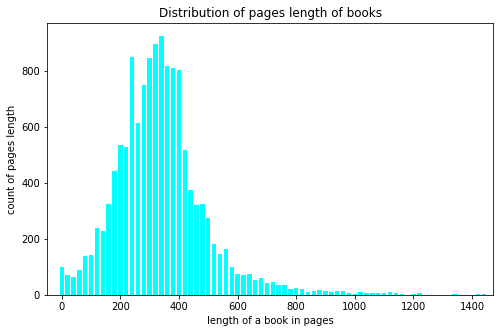

In [91]:
bins = np.arange(api_data.pages.min(), api_data.pages.max()+10, 20)

plt.figure(figsize=(8, 5))
plt.hist(data=api_data, x="pages", bins= bins, facecolor = 'cyan', rwidth=0.75, align='left')
plt.title("Distribution of pages length of books")
plt.xlabel("length of a book in pages")
plt.xlim(-50, api_data.pages.max()+10)
plt.ylabel("count of pages length")
plt.show()

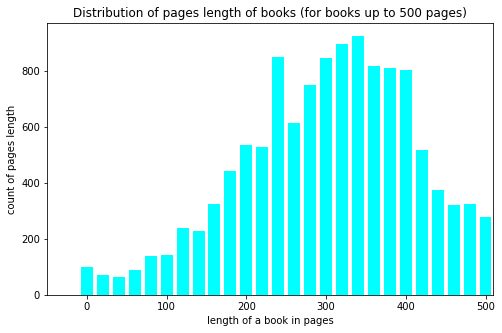

In [92]:
# zooming on pages length in interval from 0  to 500

bins = np.arange(api_data.pages.min(), 500+21, 20)

plt.figure(figsize=(8, 5))
plt.hist(data=api_data, x="pages", bins= bins, facecolor = 'cyan', rwidth=0.75, align='left')
plt.title("Distribution of pages length of books (for books up to 500 pages)")
plt.xlim(-50, 500+10)
plt.xlabel("length of a book in pages")
plt.ylabel("count of pages length")
plt.show()

In [93]:
# looking on language distribution
api_data.language.value_counts()

en       12709
de         332
es         128
fr         126
it          34
nl           4
ca           2
pt-BR        2
Name: language, dtype: int64

In [94]:
# keeping only books in English
api_data = api_data[api_data.language=="en"]

In [95]:
# looking on categories distribution
api_data.category.value_counts()

Fiction                                                                                            8336
Juvenile Fiction                                                                                    733
Biography & Autobiography                                                                           486
Humor                                                                                               250
Religion                                                                                            108
History                                                                                             103
Social Science                                                                                       95
Self-Help                                                                                            90
Body, Mind & Spirit                                                                                  79
Family & Relationships                                          

In [96]:
# how many categories/genres of books do we have?
api_data.category.nunique()

718

That's way too many categories. Some duplicates are result of lowercase/uppercase mix, some are too narrow categories like *astrology and marriage* or *Czech Americans**. In next cells I wil try to decrease number of categories.

In [97]:
api_data.category = api_data.category.str.lower()
api_data["category"] = api_data["category"].str.replace('"',  '')

In [98]:
api_data.category.nunique()

711

In [99]:
api_data.category = api_data.category.fillna("other")

In [100]:
cat_list = list(api_data.category.unique())
substring = "fiction"

list_with_substring = [string for string in cat_list if substring in string]
print(list_with_substring)

['fiction', 'american fiction', 'juvenile fiction', 'fantasy fiction', 'young adult nonfiction', 'english fiction', 'continental european fiction (fictional works by one author).', 'juvenile nonfiction', 'colombian fiction', 'domestic fiction', 'british and irish fiction (fictional works by one author).', 'science fiction, american', 'science fiction', 'humourous fiction', 'fantasy fiction, english', 'fantasy fiction, american', 'young adult fiction', 'psychological fiction', 'epistolary fiction', 'italian fiction', 'autobiographical fiction', 'french-canadian fiction', 'canadian fiction', 'fiction in english', 'australian fiction', 'diary fiction', 'occult fiction', 'christian fiction', 'science fiction comic books, strips, etc', 'didactic fiction', 'horror fiction, american', 'historical fiction', 'romance fiction', 'african american fiction', 'biographical fiction', 'domestic fiction, canadian', 'england fiction', 'catholic fiction', 'romance fiction, american', 'science fiction, en

In [101]:
cat_list = list(api_data.category.unique())
substring = "nonfiction"

list_w_non_fic_young = [string for string in cat_list if substring in string]
print(list_w_non_fic_young)

['young adult nonfiction', 'juvenile nonfiction']


In [102]:
api_data.category = api_data.category.apply(lambda x: "juvenile nonfiction" if x in list_w_non_fic_young else x)

In [103]:
cat_list = list(api_data.category.unique())
substring = "science fiction"

list_w_science_fic = [string for string in cat_list if substring in string]
print(list_w_science_fic)

['science fiction, american', 'science fiction', 'science fiction comic books, strips, etc', 'science fiction, english']


In [104]:
api_data.category = api_data.category.apply(lambda x: "scifi" if x in list_w_science_fic else x)

In [105]:
cat_list = list(api_data.category.unique())
substring = "fantasy"

list_w_fantasy = [string for string in cat_list if substring in string]
print(list_w_fantasy)

['fantasy fiction', 'fantasy', 'fantasy fiction, english', 'fantasy fiction, american', 'fantasy.', 'fantasy comic books, strips, etc', 'comic fantasy']


In [106]:
api_data.category = api_data.category.apply(lambda x: "fantasy" if x in list_w_fantasy else x)

In [107]:
cat_list = list(api_data.category.unique())
substring = "horror"

list_w_horror = [string for string in cat_list if substring in string]
print(list_w_horror)

['horror tales', 'horror tales, american', 'horror stories', 'horror fiction, american', 'horror tales, american.']


In [108]:
api_data.category = api_data.category.apply(lambda x: "horror" if x in list_w_horror else x)

In [109]:
cat_list = list(api_data.category.unique())
substring = "romance"

list_w_rom = [string for string in cat_list if substring in string]
print(list_w_rom)

['romance fiction', 'arthurian romances', 'romance fiction, american']


In [110]:
api_data.category = api_data.category.apply(lambda x: "romance" if x in list_w_rom else x)

In [111]:
cat_list = list(api_data.category.unique())
substring = "humo"

list_w_humor = [string for string in cat_list if substring in string]
print(list_w_humor)

['humor', 'black humor', 'humourous fiction', 'american wit and humor, pictorial', 'american wit and humor', 'humorous stories', 'black humor (literature)', 'american wit and humor.', 'english wit and humor']


In [112]:
api_data.category = api_data.category.apply(lambda x: "humor" if x in list_w_humor else x)

In [113]:
cat_list = list(api_data.category.unique())
substring = "childrens"

list_w_childrens = [string for string in cat_list if substring in string]
list_w_childrens.append("fairy tales")
list_w_childrens.append("toy and movable books")
print(list_w_childrens)

['childrens stories', 'childrens literature', 'childrens audiobooks', 'childrens stories, american', 'childrens stories, english', 'childrens stories, danish', 'childrens poetry', 'fairy tales', 'toy and movable books']


In [114]:
api_data.category = api_data.category.apply(lambda x: "childrens books" if x in list_w_childrens else x)

In [115]:
cat_list = list(api_data.category.unique())
substring = "poet"

list_w_poet = [string for string in cat_list if substring in string]
print(list_w_poet)

['american poetry', 'poetry', 'love poetry, spanish', 'epic poetry, greek', 'classical poetry', 'english poetry']


In [116]:
api_data.category = api_data.category.apply(lambda x: "poetry" if x in list_w_poet else x)

In [117]:
cat_list = list(api_data.category.unique())
substring = "biograp"

list_w_biograp = [string for string in cat_list if substring in string]
print(list_w_biograp)

['biography & autobiography', 'autobiographical fiction', 'biographers', 'biographical fiction', 'biography']


In [118]:
api_data.category = api_data.category.apply(lambda x: "biography & autobiography" if x in list_w_biograp else x)

In [119]:
(api_data.category.value_counts()).head(150)

fiction                                    8393
juvenile fiction                            740
biography & autobiography                   497
humor                                       268
other                                       140
religion                                    108
history                                     103
social science                               95
self-help                                    90
family & relationships                       80
body, mind & spirit                          79
business & economics                         58
true crime                                   57
travel                                       52
poetry                                       49
health & fitness                             49
fantasy                                      47
drama                                        45
juvenile nonfiction                          40
psychology                                   38
comics & graphic novels                 

In [120]:
cat_list = list(api_data.category.unique())
substring = "polit"

list_w_polit = [string for string in cat_list if substring in string]
print(list_w_polit)

['political science', 'political ethics', 'political leadership']


In [121]:
api_data.category = api_data.category.apply(lambda x: "about politics" if x in list_w_polit else x)

In [122]:
cat_list = list(api_data.category.unique())
substring = "cook"

list_w_cook = [string for string in cat_list if substring in string]
print(list_w_cook)

['african american women cooks', 'cooking', 'cookery', 'cookbooks', 'cooking, spanish']


In [123]:
api_data.category = api_data.category.apply(lambda x: "cooking" if x in list_w_cook else x)

In [124]:
cat_list = list(api_data.category.unique())
substring = "crime"

list_w_crime = [string for string in cat_list if substring in string]
print(list_w_crime)

['true crime', 'crimes without victims', 'crime']


In [125]:
api_data.category = api_data.category.apply(lambda x: "crime" if x in list_w_crime else x)

In [126]:
cat_list = list(api_data.category.unique())
substring = "adventur"

list_w_adventur = [string for string in cat_list if substring in string]
print(list_w_adventur)

['adventure stories', 'adventure games', 'adventure and adventurers']


In [127]:
api_data.category = api_data.category.apply(lambda x: "adventure" if x in list_w_adventur else x)

In [128]:
cat_list = list(api_data.category.unique())
substring = "christi"

list_w_christi = [string for string in cat_list if substring in string]
print(list_w_christi)

['christian pilgrims and pilgrimages', 'christianity', 'rapture (christian eschatology)', 'christian life', 'christian fiction']


In [129]:
api_data.category = api_data.category.apply(lambda x: "christian literature" if x in list_w_christi else x)

In [130]:
cat_list = list(api_data.category.unique())
substring = "drama"

list_w_drama = [string for string in cat_list if substring in string]
print(list_w_drama)

['drama', 'american drama', 'english drama (tragedy)', 'classical drama']


In [131]:
api_data.category = api_data.category.apply(lambda x: "drama" if x in list_w_drama else x)

In [132]:
cat_list = list(api_data.category.unique())
substring = "psycho"

list_w_psycho = [string for string in cat_list if substring in string]
print(list_w_psycho)

['psychology', 'child psychologists', 'alienation (social psychology)', 'psychological fiction', 'african american psychologists', 'developmental psychology', 'maturation (psychology)', 'child psychology', 'archetype (psychology)']


In [133]:
api_data.category = api_data.category.apply(lambda x: "psychology" if x in list_w_psycho else x)

In [134]:
cat_list = list(api_data.category.unique())
substring = "animal"

list_w_animal = [string for string in cat_list if substring in string]
print(list_w_animal)

['animal behavior', 'animals, mythical', 'animal rights', 'animals', 'animal stories', 'animal welfare']


In [135]:
api_data.category = api_data.category.apply(lambda x: "animals" if x in list_w_animal else x)

In [136]:
cat_list = list(api_data.category.unique())
substring = "comput"

list_w_comput = [string for string in cat_list if substring in string]
print(list_w_comput)

['computers', 'apple ii (computer)']


In [137]:
api_data.category = api_data.category.apply(lambda x: "computers" if x in list_w_comput else x)

In [138]:
cat_list = list(api_data.category.unique())
substring = "econom"

list_w_econom = [string for string in cat_list if substring in string]
print(list_w_econom)

['business & economics', 'employment (economic theory)', 'consumption (economics)', 'home economics']


In [139]:
api_data.category = api_data.category.apply(lambda x: "economics" if x in list_w_econom else x)

In [140]:
cat_list = list(api_data.category.unique())
substring = "archit"

list_w_archit = [string for string in cat_list if substring in string]
print(list_w_archit)

['architecture', 'architects']


In [141]:
api_data.category = api_data.category.apply(lambda x: "architecture" if x in list_w_archit else x)

In [142]:
fantasy_list = ["elves", "dragons", "baggins, frodo (fictitious character)", 
                "dracula, count (fictitious character)", "frankenstein (fictitious character)",
               "discworld (imaginary place)", "buffy the vampire slayer (fictitious character)",
               "hobbits (fictitious characters)", "middle earth (imaginary place)",
               "baggins, bilbo (fictitious character)", "alice (fictitious character : carroll)",
               "vampires"]
api_data.category = api_data.category.apply(lambda x: "fantasy" if x in fantasy_list else x)

In [143]:
cat_list = list(api_data.category.unique())
substring = "love"

list_w_love = [string for string in cat_list if substring in string]
print(list_w_love)

['love stories', 'love stories, american', 'love stories, english', 'love', 'lovely story']


In [144]:
api_data.category = api_data.category.apply(lambda x: "romance" if x in list_w_love else x)

In [145]:
cat_list = list(api_data.category.unique())
substring = "game"

list_w_game = [string for string in cat_list if substring in string]
print(list_w_game)

['games', 'scrabble (game)', 'games & activities']


In [146]:
api_data.category = api_data.category.apply(lambda x: "games" if x in list_w_game else x)

In [147]:
cat_list = list(api_data.category.unique())
substring = "health"

list_w_health = [string for string in cat_list if substring in string]
print(list_w_health)

['health & fitness', 'health']


In [148]:
api_data.category = api_data.category.apply(lambda x: "health & fitness" if x in list_w_health else x)

In [149]:
cat_list = list(api_data.category.unique())
substring = "lang"

list_w_lang = [string for string in cat_list if substring in string]
print(list_w_lang)

['language arts & disciplines', 'english language']


In [150]:
api_data.category = api_data.category.apply(lambda x: "foreign languages and English" if x in list_w_lang else x)

In [151]:
pet_list = ["pets", "cats", "dogs", "veterinarians", "cat owners"]
api_data.category = api_data.category.apply(lambda x: "pets" if x in pet_list else x)

religion_list = ["bible", "good and evil", "cults","angels", "anti-clericalism", "hell", "devil",
                "amish", "god"]
api_data.category = api_data.category.apply(lambda x: "religion" if x in religion_list else x)

family_list = ["families", "brothers and sisters", "man-woman relationships", "aunts", 
               "brothers", "friendship", "female friendship", "abused wives", "interpersonal relations",
              "communication in marriage", "abusive men", "fathers", "divorced women", "aging parents", 
               "motherhood", "mothers and daughters", "abused children", "child abuse", "fathers and daughters",
              "children of divorced parents", "divorced mothers"]
api_data.category = api_data.category.apply(lambda x: "family & relationships" if x in family_list else x)

scifi_list = ["interplanetary voyages", "life on other planets", "dune (imaginary place)", "dystopias",
             "time travel", "atreides, paul (fictitious character)", "ender (fictitious character)", 
              "extraterrestrial beings"]
api_data.category = api_data.category.apply(lambda x: "scifi" if x in scifi_list else x)

crime_list = ["detective and mystery stories", "police", "private investigators", "murder",
             "ex-convicts", "abduction.", "arson", "insurance fraud", "forensic pathologists",
             "kidnapping", "criminals", "burglary", "homicide investigation", "assassins", "drug traffic"]
api_data.category = api_data.category.apply(lambda x: "crime" if x in crime_list else x)

In [152]:
cat_list = list(api_data.category.unique())
substring = "gay"

list_w_gay = [string for string in cat_list if substring in string]
list_w_gay.append("lesbians")
print(list_w_gay)

['gay men', 'lesbians']


In [153]:
api_data.category = api_data.category.apply(lambda x: "LGBT literature" if x in list_w_gay else x)

In [154]:
cat_list = list(api_data.category.unique())
substring = "ghost"

list_w_ghost = [string for string in cat_list if substring in string]
list_w_ghost.append("cemeteries")
print(list_w_ghost)

['ghost stories, american', 'ghost stories, english', 'cemeteries']


In [155]:
api_data.category = api_data.category.apply(lambda x: "ghost and dark stories" if x in list_w_ghost else x)

In [156]:
cat_list = list(api_data.category.unique())
substring = "music"

list_w_music = [string for string in cat_list if substring in string]
print(list_w_music)

['music', 'music trade', 'rock musicians', 'authors as musicians']


In [157]:
api_data.category = api_data.category.apply(lambda x: "music" if x in list_w_music else x)

In [158]:
cat_list = list(api_data.category.unique())
substring = "finan"

list_w_fin = [string for string in cat_list if substring in string]
print(list_w_fin)

['capitalists and financiers', 'finance, personal', 'finance']


In [159]:
api_data.category = api_data.category.apply(lambda x: "business and finance" if x in list_w_fin else x)

In [160]:
cat_list = list(api_data.category.unique())
substring = "busines"

list_w_bus= [string for string in cat_list if substring in string]
print(list_w_bus)

['business and finance', 'businessmen', 'business intelligence', 'businesswomen', 'business ethics']


In [161]:
api_data.category = api_data.category.apply(lambda x: "business and finance" if x in list_w_bus else x)

In [162]:
cat_list = list(api_data.category.unique())
substring = "travel"

list_w_travel= [string for string in cat_list if substring in string]
print(list_w_travel)

['travel', 'travel in literature', 'air travel']


In [163]:
api_data.category = api_data.category.apply(lambda x: "travel" if x in list_w_travel else x)

In [164]:
cat_list = list(api_data.category.unique())
substring = "depres"

list_w_depres= [string for string in cat_list if substring in string]
depres_add = ["fear", "mental illness", "dangerously mentally ill", "alcoholics",
             "multiple personality"]
for problem in depres_add:
    list_w_depres.append(problem)
print(list_w_depres)

['depressions', 'antidepressants', 'fear', 'mental illness', 'dangerously mentally ill', 'alcoholics', 'multiple personality']


In [165]:
api_data.category = api_data.category.apply(lambda x: "mental health problems" if x in list_w_depres else x)

In [166]:
cat_list = list(api_data.category.unique())
substring = "comic"

list_w_com= [string for string in cat_list if substring in string]
print(list_w_com)

['comics & graphic novels', 'comics & graphic novels.', 'comic books, strips, etc']


In [167]:
api_data.category = api_data.category.apply(lambda x: "comics" if x in list_w_com else x)

In [168]:
young_list = ["juvenile fiction", "juvenile nonfiction", "boys", "young adult fiction",
             "adolescence"]
api_data.category = api_data.category.apply(lambda x: "books for young adults" if x in young_list else x)

In [169]:
# how were we successful in decreasing categories from original 718 categories?
api_data.category.nunique()

545

In [170]:
# what are our new categories?
cat_table = api_data.category.value_counts().to_frame().reset_index()
cat_table.head(150)

,index,category
0,fiction,8393
1,books for young adults,809
2,biography & autobiography,497
3,humor,268
4,other,140
5,family & relationships,136
6,religion,131
7,history,103
8,crime,103
9,social science,95


In [171]:
# how many categories have at least 5 books?
len(cat_table[cat_table.category>4])

76

In [172]:
# renaming categories with less than 5 books
cat_table = cat_table[cat_table.category>4]
cat_to_keep = list(cat_table["index"])

api_data.category = api_data.category.apply(lambda x: "other" if x not in cat_to_keep else x)

In [173]:
# removing other as category because it stores no information
api_data = api_data[(api_data.category != "other")]

In [174]:
# checking data types and null values
api_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11979 entries, 1 to 13336
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   google_id    11979 non-null  object
 1   title        11979 non-null  object
 2   description  11873 non-null  object
 3   isbn_api     11979 non-null  object
 4   category     11979 non-null  object
 5   language     11979 non-null  object
 6   pages        11979 non-null  int32 
dtypes: int32(1), object(6)
memory usage: 701.9+ KB


In [175]:
# checking dataset for not usefull variables
books_readers.head()

,user,age,country_2,isbn,rating,rating_count,avg_rating,reaction_index,title,author,year,publisher,median_age_raters
0,8,NaN,canada,0002005018,5,9,7.666667,0.642857,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,30.0
1,11676,NaN,other,0002005018,8,9,7.666667,0.642857,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,30.0
2,67544,30.0,canada,0002005018,8,9,7.666667,0.642857,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,30.0
3,116866,NaN,other,0002005018,9,9,7.666667,0.642857,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,30.0
4,123629,NaN,canada,0002005018,9,9,7.666667,0.642857,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,30.0


In [176]:
# I don't believe different publisher of year of publishing influence if person likes certain book
books_readers.drop(['year', 'publisher'], axis=1, inplace=True)

In [177]:
# joing all data together
final_df = pd.merge(books_readers, api_data, left_on="isbn", right_on="isbn_api")
final_df.drop(['google_id', 'isbn_api'], axis=1, inplace=True)
final_df.sample(20)

,user,age,country_2,isbn,rating,rating_count,avg_rating,reaction_index,title_x,author,median_age_raters,title_y,description,category,language,pages
87205,12705,36.0,usa,0446530077,10,39,7.000000,0.458824,Find Me,Rosie O'Donnell,36.5,Find Me,"Part memoir, part mystery, 'Find Me' is a tale...",literary criticism,en,224
7882,26421,NaN,usa,1558743669,10,134,8.000000,0.511450,"A Child Called \It\"": One Child's Courage to S...",Dave Pelzer,32.0,A Child Called It,Tells the story of a child's abuse at the hand...,biography & autobiography,en,184
169442,162052,51.0,usa,0316107255,4,8,8.125000,0.421053,Penguin Dreams and Stranger Things (A Bloom Co...,Berke Breathed,41.0,Penguin Dreams and Stranger Things,"Milo, Binkley, Steve Dallas, Opus the Penguin,...",humor,en,120
3601,92810,60.0,usa,0449006522,7,51,7.627451,0.459459,Manhattan Hunt Club,JOHN SAUL,40.0,The Manhattan Hunt Club,When college student Jeff Converse is wrongly ...,fiction,en,367
60421,149511,NaN,germany,0553575384,8,31,8.258065,0.407895,To Say Nothing of the Dog,Connie Willis,38.0,"To Say Nothing of the Dog, Or, How We Found th...",Ned Henry shuttles between the 1940s and the t...,fiction,en,493
54849,75971,NaN,usa,0451156609,8,75,7.160000,0.441176,The Tommyknockers,Stephen King,31.0,The Tommyknockers,A small Maine town stands on the verge of self...,fiction,en,747
78599,55492,43.0,usa,0671880314,4,36,8.305556,0.302521,Schindler's List,Thomas Keneally,37.0,Schindler's List,Recreates the remarkable activities and courag...,fiction,en,398
80758,95359,33.0,usa,014023313X,8,61,7.491803,0.329730,The Stone Diaries,Carol Shields,34.5,The Stone Diaries,"From her birth in rural Manitoba, to her journ...",fiction,en,361
24356,116183,NaN,usa,0142001430,8,88,8.318182,0.520710,Year of Wonders,Geraldine Brooks,37.0,Year of Wonders,Eighteen-year-old Anna Frith tells the story o...,fiction,en,308
54500,139827,NaN,usa,0380726297,9,12,8.416667,0.413793,Sacred,Dennis Lehane,46.0,Sacred,A dying billionaire hires private investigator...,fiction,en,400


In [178]:
# keeping only books in English in dataset  
final_df = final_df[final_df.language=="en"]
final_df.drop("language", axis=1, inplace=True)

In [184]:
final_df[final_df.pages<1]

,user,age,country_2,isbn,rating,rating_count,avg_rating,reaction_index,title,author,median_age_raters,title_api,description,category,pages
58182,5543,29.0,usa,0880389206,9,8,8.750000,0.444444,exile (forgotten realms: dark elf trilogy),r. a. salvatore,29.0,the dark elf trilogy,Travel back to strange and exotic Menzoberranz...,fantasy,0
58183,76223,25.0,portugal,0880389206,7,8,8.750000,0.444444,exile (forgotten realms: dark elf trilogy),r. a. salvatore,29.0,the dark elf trilogy,Travel back to strange and exotic Menzoberranz...,fantasy,0
58184,98518,NaN,usa,0880389206,10,8,8.750000,0.444444,exile (forgotten realms: dark elf trilogy),r. a. salvatore,29.0,the dark elf trilogy,Travel back to strange and exotic Menzoberranz...,fantasy,0
58185,101851,29.0,usa,0880389206,8,8,8.750000,0.444444,exile (forgotten realms: dark elf trilogy),r. a. salvatore,29.0,the dark elf trilogy,Travel back to strange and exotic Menzoberranz...,fantasy,0
58186,113983,39.0,usa,0880389206,9,8,8.750000,0.444444,exile (forgotten realms: dark elf trilogy),r. a. salvatore,29.0,the dark elf trilogy,Travel back to strange and exotic Menzoberranz...,fantasy,0
58187,252007,35.0,germany,0880389206,9,8,8.750000,0.444444,exile (forgotten realms: dark elf trilogy),r. a. salvatore,29.0,the dark elf trilogy,Travel back to strange and exotic Menzoberranz...,fantasy,0
58188,258152,29.0,canada,0880389206,8,8,8.750000,0.444444,exile (forgotten realms: dark elf trilogy),r. a. salvatore,29.0,the dark elf trilogy,Travel back to strange and exotic Menzoberranz...,fantasy,0
58189,259757,25.0,usa,0880389206,10,8,8.750000,0.444444,exile (forgotten realms: dark elf trilogy),r. a. salvatore,29.0,the dark elf trilogy,Travel back to strange and exotic Menzoberranz...,fantasy,0
58190,5543,29.0,usa,1560760478,9,6,8.333333,0.352941,sojourn (forgotten realms novel: dark elf tril...,r.a. salvatore,29.0,the dark elf trilogy,Travel back to strange and exotic Menzoberranz...,fantasy,0
58191,35030,26.0,usa,1560760478,7,6,8.333333,0.352941,sojourn (forgotten realms novel: dark elf tril...,r.a. salvatore,29.0,the dark elf trilogy,Travel back to strange and exotic Menzoberranz...,fantasy,0


In [179]:
# checking number of unique valus for text variables before changes
final_df.author.nunique(), final_df.title_x.nunique(), final_df.title_y.nunique()

(4282, 10673, 9498)

In [180]:
# unifying text variable to remove some duplicates
final_df.title_x = final_df.title_x.str.lower().str.strip()
final_df.title_y = final_df.title_y.str.lower().str.strip()
final_df.author = final_df.author.str.lower().str.strip()

In [181]:
# checking number of unique valus for text variables after changes
final_df.author.nunique(), final_df.title_x.nunique(), final_df.title_y.nunique()

(3973, 10587, 9432)

In [182]:
# more clear names for title variables
final_df.rename(columns={'title_x': 'title'}, inplace=True)
final_df.rename(columns={'title_y': 'title_api'}, inplace=True)

In [183]:
# saving all data for later creation of recommender system
final_df.to_csv(r"C:\Users\kamil\OneDrive\Plocha\Projects\books\final.csv")

### Sources

- [Scraping-and-investigating-the-most-recommended-books](https://github.com/teb86/Scraping-and-investigating-the-most-recommended-books/blob/master/mostrecommendedbooks.ipynb) : for using Google Books API
- [Books Crossing Dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/) : for Books dataset